# Rice Image Classification using CNN
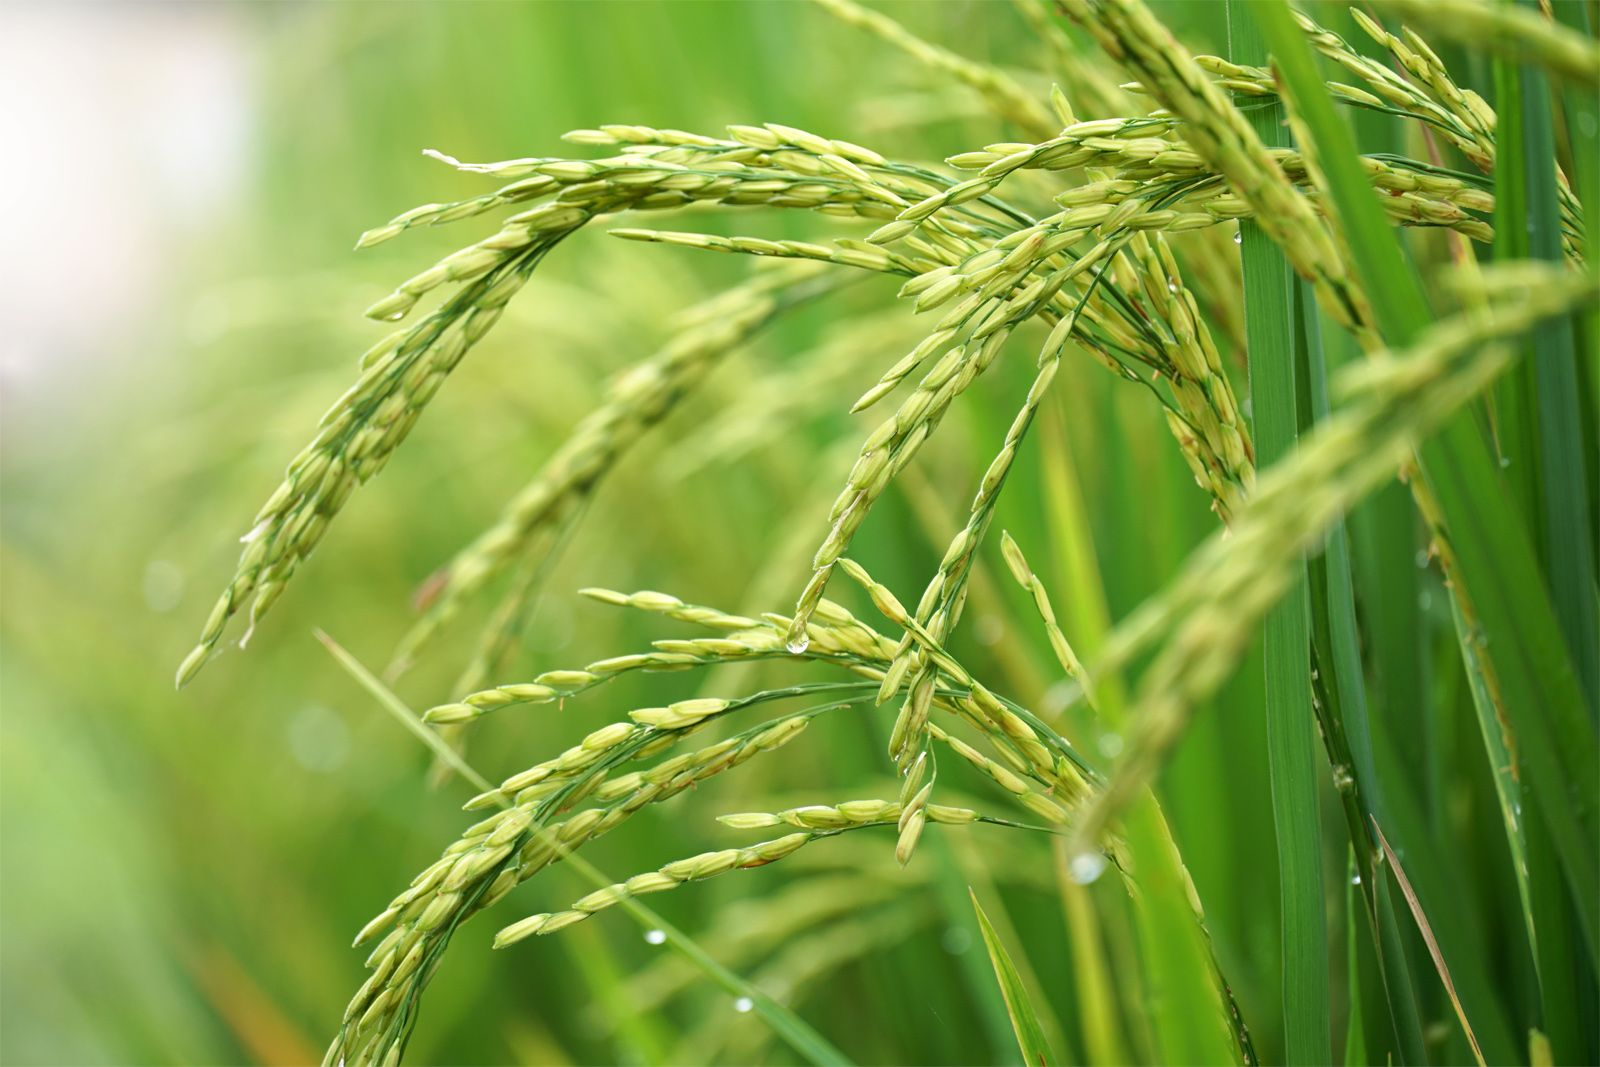

## 1. Introduction
We have 5 types of rice images with 15k images for each class of the [Rice Image Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset?datasetId=2049052%3DRice_Image_Dataset&select=Rice_Image_Dataset). We have to train the Deep learning model to classify each type of rice.


**Rice Type**
1. Arborio
2. Basmati
3. Ipsala
4. Jasmine
5. Karacadag

**Planning**
1. First build Convolution Neural Network (CNN) to solve this problem.
2. Try out transfer learning technique to find better accuracy than ANN

## 2. Data Preparation

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import opendatasets as od
import matplotlib.image as img
import random
import pathlib 
import os

In [6]:
# Dowload the dataset
dataset_url = 'https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset?datasetId=2049052%3DRice_Image_Dataset&select=Rice_Image_Dataset'
# Look into the data directory
dataset_dir = './rice-image-dataset/Rice_Image_Dataset'
data_dir = pathlib.Path(dataset_dir)
if not os.path.isdir(dataset_dir):
    od.download(dataset_url)

classes = os.listdir(dataset_dir)[1:]
print(classes)

['Jasmine', 'Arborio', 'Karacadag', 'Ipsala', 'Basmati']


### I. Quick look at the downloaded data

Let's check number of files in each classes

In [7]:
images_per_class = []
all_classes = []
for class_name in classes:
    total_images = len(os.listdir(os.path.join(dataset_dir, class_name)))
    images_per_class.append(total_images)
    all_classes.append(class_name)
    print(f'{class_name.capitalize()}: contains {total_images} images')

Jasmine: contains 15000 images
Arborio: contains 15000 images
Karacadag: contains 15000 images
Ipsala: contains 15000 images
Basmati: contains 15000 images


In [ ]:
df = pd.DataFrame({'images_per_class': images_per_class, 'all_classes': all_classes}, index=all_classes)
df.plot.pie(y= 'images_per_class', startangle = 0, autopct='%1.1f%%', figsize=(11, 6))
plt.legend('', frameon=False)
plt.show()

Checking the sample images to get better idea about the data

In [ ]:
arborio = list(data_dir.glob('Arborio/*'))[:600]
basmati = list(data_dir.glob('Basmati/*'))[:600]
ipsala = list(data_dir.glob('Ipsala/*'))[:600]
jasmine = list(data_dir.glob('Jasmine/*'))[:600]
karacadag = list(data_dir.glob('Karacadag/*'))[:600]

In [ ]:
rand_idx = random.randint(0, 600)
rand_idx

In [ ]:
classes

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Categories')

jasmine_image = img.imread(jasmine[rand_idx])
arborio_image = img.imread(arborio[rand_idx])
karacadag_image = img.imread(karacadag[rand_idx])
ipsala_image = img.imread(ipsala[rand_idx])
basmati_image = img.imread(basmati[rand_idx])

classes_img = [jasmine_image, arborio_image, karacadag_image, ipsala_image, basmati_image]
for i, (class_name, image) in enumerate(zip(classes, classes_img)):
    ax[i].set_title(f'{class_name}, {image.shape}')
    ax[i].imshow(image)
plt.show()


### II. Load data into the memory
https://www.tensorflow.org/tutorials/load_data/images

In [8]:
batch_size = 64
img_height = 200
img_width = 200

In [10]:
train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
train_ds

Found 75000 files belonging to 5 classes.
Using 60000 files for training.


2023-01-21 14:29:04.026394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 14:29:04.026566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 14:29:04.026677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 14:29:04.026820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 14:29:04.026929: I tensorflow/compiler/xla/stream_executo

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds

Found 75000 files belonging to 5 classes.
Using 15000 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Standardize the data

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
import numpy as np

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
img_batch, labels_batch = next(iter(normalized_ds))

first_image = img_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Configure the dataset for performance

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
# dataset.cache - keeps the images in memory after they are loaded off disk during the first epoch.
# to avoid bottleneck while training
# Dataset.prefetch - overlaps data preprocessing and model excecution while training
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 3. CNN Model

## Defining the Model (Convolutional Neural Network)

> The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel. - [Source](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">


Let us implement a convolution operation on a 1 channel image with a 3x3 kernel.

For multi-channel images, a different kernel is applied to each channels, and the outputs are added together pixel-wise. 

Checking out the following articles to gain a better understanding of convolutions:

1. [Intuitively understanding Convolutions for Deep Learning](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) by Irhum Shafkat
2. [Convolutions in Depth](https://sgugger.github.io/convolution-in-depth.html) by Sylvian Gugger (this article implements convolutions from scratch)

There are certain advantages offered by convolutional layers when working with image data:

* **Fewer parameters**: A small set of parameters (the kernel) is used to calculate outputs of the entire image, so the model has much fewer parameters compared to a fully connected layer. 
* **Sparsity of connections**: In each layer, each output element only depends on a small number of input elements, which makes the forward and backward passes more efficient.
* **Parameter sharing and spatial invariance**: The features learned by a kernel in one part of the image can be used to detect similar pattern in a different part of another image.

We will also use a [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) layers to progressively decrease the height & width of the output tensors from each convolutional layer.

<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" style="max-width:400px;">

Before we define the entire model, let's look at how a single convolutional layer followed by a max-pooling layer operates on the data.